# Assignment 5: Text classification - Naive Bayes
**Dataset**: [Customer reviews](http://www.cse.chalmers.se/~richajo/dit862/data/all_sentiment_shuffled.txt)

**Goals**: Implementing the Naive Bayes classification method and use it for sentiment classification of customer reviews


## Loading data
The original dataset is formatted in .txt, we will reformat and store data into dataframe for our convenience.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt


In [2]:
# Getting data from url
import base64
import requests
re = requests.get ('http://www.cse.chalmers.se/~richajo/dit862/data/all_sentiment_shuffled.txt')
re.encoding = 'utf-8'
data = re.text

## Data Preprocessing

### Reformatting the Data

In [3]:
# Printing data type and observing the original format of the data
print("data's type:  ", type(data))
print(data[:200])

data's type:   <class 'str'>
music neg 241.txt i bought this album because i loved the title song . it 's such a great song , how bad can the rest of the album be , right ? well , the rest of the songs are just filler and are n't


The original data is naturally string with one review per line. We can split these reviews and reformat into the data dataframe type. Also, each line includes topic labels, sentiment labels, document ids, and reviews. We expect to use reviews and sentiment labels only; therefore, we will separate these parts in each line and store them into a dataframe format for our convenience.

In [4]:
# Reformatting the data

# Creating empty lists of 4 data attributes:  reviews, topics, labels, and documment ids
reviews, topics, labels, doc_id = [],[],[],[]

# Looping over lines to separate them into separated attributes
for line in data.splitlines():
  reviews.append(' '.join(token for token in line.split()[3:]))
  topics.append(line.split()[0])
  labels.append(line.split()[1])
  doc_id.append(line.split()[2])

# Storing the separated data into dataframe
df = pd.DataFrame(zip(doc_id, reviews, topics, labels), columns = ['doc_id', 'review', 'topic', 'label'])
print("data's shape: ", df.shape)
df.head()

data's shape:  (11914, 4)


,doc_id,review,topic,label
0,241.txt,i bought this album because i loved the title ...,music,neg
1,544.txt,i was misled and thought i was buying the enti...,music,neg
2,729.txt,"i have introduced many of my ell , high school...",books,neg
3,278.txt,anything you purchase in the left behind serie...,books,pos
4,840.txt,"i loved these movies , and i cant wiat for the...",dvd,pos


The dataset has 11,914 reviews, and 4 attributes/columns:doc_id, review, topic, label

### Identifying missing values

In [5]:
df.isnull().sum()

doc_id    0
review    0
topic     0
label     0
dtype: int64

We can see there is no missing values in our data, so we do not need to do any data imputing. 

### Exploring the dependent variable

data distribution in the dependent variable:
 pos    6000
neg    5914
Name: label, dtype: int64


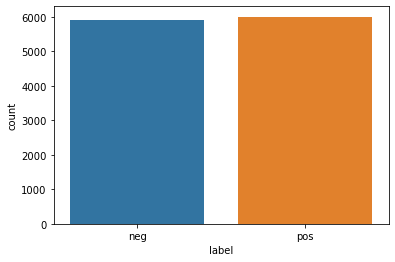

In [6]:
print('data distribution in the dependent variable:\n', df['label'].value_counts())
sns.countplot(data = df, x = 'label')
plt.show()

Fortunately, the data equally distributes in two classes of the dependent variable.

Here, we have to encode labeled classes into numerics so that the machine can understand.

In [7]:
# Encoding the target labels into the numeric type
df['label'] = np.where(df['label']=='pos', 1, 0)
df.head()

,doc_id,review,topic,label
0,241.txt,i bought this album because i loved the title ...,music,0
1,544.txt,i was misled and thought i was buying the enti...,music,0
2,729.txt,"i have introduced many of my ell , high school...",books,0
3,278.txt,anything you purchase in the left behind serie...,books,1
4,840.txt,"i loved these movies , and i cant wiat for the...",dvd,1


### Cleaning data
When doing text classification, data cleaning is an essential part, deciding the model's performance. Some stopwords such as 'the','a', etc. occur most frequently, but contain no useful information. We expect to remove these words from the corpus to reduce feature dimensions that may improve perfomance of models.

#### Removing stop words, numeric, and non-letter tokens

In [8]:
# Downloading a stopword list in English
!pip install stop-words
from stop_words import get_stop_words
stop_words = get_stop_words('en')

# Removing stopwords, and numerics 
df['review'] = df['review'].apply( lambda x: ' '.join([x for x in str(x).split() if not x.isdigit() and not x.isspace() ]) )
df['review'] = df['review'].apply( lambda x: ' '.join([x for x in str(x).split() if x not in stop_words]) )
df['review'].head()

0    bought album loved title song . 's great song ...
1    misled thought buying entire cd contains one song
2    introduced many ell , high school students loi...
3    anything purchase left behind series excellent...
4    loved movies , cant wiat third one ! funny , s...
Name: review, dtype: object

In [9]:
# Removing punctuations and non-letter tokens
df['review']=df['review'].str.replace('[^\w\s]','')
df['review'].head()

0    bought album loved title song  s great song  b...
1    misled thought buying entire cd contains one song
2    introduced many ell  high school students lois...
3    anything purchase left behind series excellent...
4    loved movies  cant wiat third one  funny  suit...
Name: review, dtype: object

## Developping a Naive Bayes model
We are going to implement the Naive Bayes algorithm for multinomially distributed data. 
The Naive Bayes make assumptions that all attributes or hereby words are independent of each other, and the word positions are unimportant. 

### Splitting the data for training and testing
We will split our data into two parts: training (80%) and test set (20%). We will split our data for training and testing before transforming it into a matrix of token counts. The reason for doing that is that we want to observe the original data (the data before transformation), together with our predicted sentiments for analyzing misclassification. If we transformed before spliting data for training and testing, we will not be able to do so.

We use the training set for training and validating the model by using k-fold cross validation with 5 folds. For each iteration, 4 folds will be used for training and 1 set for validating.

We only use the test set for our final evaluation only; meaning that it will not participate in any training steps.By doing so, we can ensure having the most reliable evaluation result before deploying the model.

In [10]:
# Splitting the data into training (80%) and test set(20%)
from sklearn.model_selection import train_test_split
X = df['review']
y = df['label']
X_train, X_test, y_train, y_test = train_test_split (X, y, train_size = 0.8, random_state = 42)
print ('Shapes of X_train, y_train: ', X_train.shape, y_train.shape)
print ('Shapes of X_test, y_test: ', X_test.shape, y_test.shape)

Shapes of X_train, y_train:  (9531,) (9531,)
Shapes of X_test, y_test:  (2383,) (2383,)


### Document representation and data tranformation
The computer is unable to read and understand text data, and features are not available in the dataset like the numeric dataset. We have to represent the text or documents into vector representation. There are a variety of methods to represent the documents such as term frequency, tf-idf, etc. Here we will count term frequency for presentating the reviews (called documents). We will tokenize each review (shown as an instance) that has been cleaned, then count the token frequency. As a result, we will have a  a matrix of token counts representing the whole corpus. Features are basically single words or tokens.

In [11]:
# Converting a collection of text documents to a matrix of token counts
from sklearn.feature_extraction.text import CountVectorizer
# Creating a vectorizer model that convert a collection of text documents to a matrix of token counts
vectorizer = CountVectorizer(lowercase = False)


#### * For the Training set

In [12]:
# For training set:
# Fitting the vectorizer model into the training set and then returning document-term matrix of that set
X_train_tf = vectorizer.fit_transform(X_train)

# Converting  sparse matrix to a dense matrix
X_train_tf_dm = X_train_tf.toarray()
print ('Shapes of transformed X_train, y_train: ', X_train_tf_dm.shape, y_train.shape)


Shapes of transformed X_train, y_train:  (9531, 47741) (9531,)


In [13]:
print('The number of features: ', len(vectorizer.get_feature_names()))

The number of features:  47741


#### * For the Test set

In [14]:
# Transforming the test set and returning document-term matrix of that set
X_test_tf = vectorizer.transform(X_test)

# Converting  sparse matrix to a dense matrix
X_test_tf_dm = X_test_tf.toarray()
print ('Shapes of transformed X_train, y_train: ', X_train_tf_dm.shape, y_train.shape)


Shapes of transformed X_train, y_train:  (9531, 47741) (9531,)


We have 47,741 features. The numer of features we have is actually the size of our vocabulary size because we did not limit the maximum number of features.

In [15]:
# Observing the documment term-matrix of the trainingset
pd.DataFrame(X_train_tf_dm, columns = vectorizer.get_feature_names())

,00,000,00000,000feet,000mb,000page,000steps,004144php,01,02071982,...,Árpád,àvis,ça,énnui,ï½50,ï½bersoldier,ï½bersoldiers,ï½kerlund,ï½lan,único
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9526,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9527,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9528,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9529,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### Training the model

In [16]:
# Creating a naive bayes models for text classification
from sklearn.naive_bayes import MultinomialNB
mnb = MultinomialNB()

# Fitting the model into the training set for learning
mnb.fit(X_train_tf_dm, y_train)

MultinomialNB()

In [17]:
# Training and validating the model using k-fold cross validation
from sklearn.model_selection import cross_validate
cv = cross_validate (mnb, X_train_tf_dm, y_train, cv = 5)
print("accuracy score of 5-fold cross validation:\n", cv['test_score'])
print("cross validation accuracy mean score: \n", cv['test_score'].mean())


accuracy score of 5-fold cross validation:
 [0.81646565 0.80902413 0.8247639  0.8158447  0.77282267]
cross validation accuracy mean score: 
 0.8077842113690601


By using the k-fold cross validation, we got a generalized estimated accuracy score of the model of around 81% This score is not high, but acceptable for the text classification. 

### Making prediction

In [18]:
# Applying the learned model to make prediction on the test set
y_pred = mnb.predict(X_test_tf_dm)

In [19]:
# Analyzing misclassified reviews
pd.set_option('display.max_colwidth', None)
test_df = pd.DataFrame(zip(X_test, y_test, y_pred), columns = ['X_test','y_test', 'y_pred'])
test_df[test_df['y_test'] != test_df['y_pred'] ][:5]

,X_test,y_test,y_pred
0,just love book s anyone practices particular religion prayers simple every day language easily understood like god speaking right find inspiring every day look forward reading one prayer per day none paragraphs speak straight heart,1,0
4,unfortunately total block work well rosacea sensitive skin caused skin become red irritated end day nt doubt excellent sunblock just rosacea sensitive skin use now arms problems feel expensive little product will repurchase,0,1
6,6year olds nt seem want play maybe hard enjoyed playing 11year old twins really liked,1,0
10,story dark full menace dark thoughts great kids ok adults s like hard story much gentleness except couple moments,0,1
14,bought trial product stuff bought nt work advertise dusters picks dust instead pushing another place refills quite cheap make cleaning job much easier,1,0


We can see some reviews are hard to classify. For example, the review 4 has the word "excellent" and "repurchase" that are positive, but it was labeled as negative. Similarly, the review 10 contains some positive words such as: "great", "ok", "like", "much", and "gentleness". The Naive Bayes algorithm assumes that words or attributes are conditionally independent, and disregards the word positions or context, although we know they are critical in natural language. This could be a good reason for explaining high misclassification rate of the model. 

### Evaluating the model
We will evaluate the model performance on the test set. We aim to evaluate the model performance with three hree popular evaluation methods: accuracy score, confusion matrix, and ROC Curve.
* With model's accuracy 

In [20]:
# Evaluating the model on the test set
print('Accuracy of the selected model in the test set: {:.4f}'.format(mnb.score(X_test_tf_dm, y_test)))

Accuracy of the selected model in the test set: 0.8028


* With confusion matrix

Text(33.0, 0.5, 'actual values')

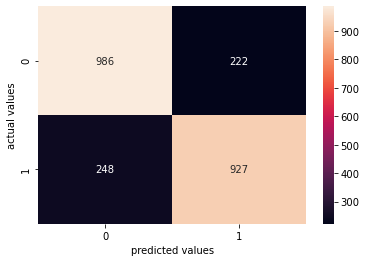

In [21]:
# Evaluating with the confusion matrix
from sklearn.metrics import confusion_matrix
conf_matrix = confusion_matrix(y_test, y_pred)
# Visualizing the confusion matrix
sns.heatmap(conf_matrix, annot = True, fmt = '.0f')
plt.xlabel ('predicted values')
plt.ylabel ('actual values')

Looking at the confusion matrix, we can see the model correctly predicted 986 negative reviews, and 927 positive reviews. However, the model incorrectly predict 248 positive reviews as negative. Likewise, 222 negative reviews were incorrectly predicted as positive. 

* With the ROOC Curve

The Receiver Operating Characteristic (ROC) Curve was created by plotting the true positive rate (TPR) against the false positive rate (FPR). The ROC Curve is a probability curve, telling us how much the model is able to distinguish between classes, shown by the area under the curve (AUC). Higher the AUC is, the better the model performs. The AUC is expected to greater than 0.5, or over left-top part compared to the baseline.

    - TPR = TP/P = TP/(TP+FN)

    - FPR = FP/N = FP/ (FP+TN)

The ROC AUC:  0.8683257010004227


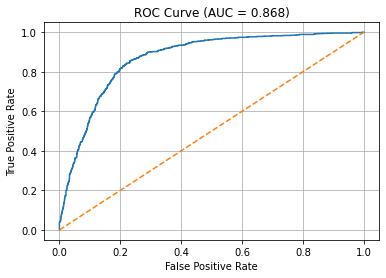

In [22]:
# Evaluating with the ROC curve
from sklearn.metrics import roc_curve, roc_auc_score
# Taking only the probability of the positive review (class 1) on the test set
y_pred_prob_c1  = mnb.predict_proba (X_test_tf_dm)[:,1]

# Getting True Positive Rate (tpr) and False Positive Rate (fpr)
fpr, tpr, threshold = roc_curve (y_test, y_pred_prob_c1, pos_label = 1)

# Computing the area under the ROC Curve (roc_auc)
roc_auc_score = roc_auc_score (y_test, y_pred_prob_c1)
print('The ROC AUC: ', roc_auc_score) 

# Visualizing the ROC Curve
plt.plot (fpr, tpr)
plt.plot([0,1], '--')
plt.xlabel ('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title ("ROC Curve (AUC = {:.3f})".format(roc_auc_score))
plt.grid()
plt.show()

The AUC above indicates that our model can distinguish the two classes (positive (1) and negative (0)) pretty well. 